<font size=7> HC21769 Buzsaki Latencies

# Import stuff, get data

I attempt to get Sury's code for analyzing connectivity working.

In [5]:
from scipy.ndimage import gaussian_filter1d

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy import signal
import math
from scipy.sparse import csr_array
import random

import pickle
from human_hip.spike_data import curate_latencies, plot_raster_latency_pairs, plot_vector_layout, read_phy_files,\
                                  plot_latency_dist_hist, plot_latency_angle_hist
from human_hip.animate import animate_latencies
from human_hip import spike_data

In [7]:

import warnings
from human_hip.spike_data import latencies, latency_times, plot_raster, plot_footprint
import diptest 
from ipywidgets import interact_manual, interact


In [8]:
sd = spike_data.read_autocurated_data( "/workspaces/human_hippocampus/data/ephys/2023-12-11-e-Hc120523_aav9hckcr1_chip21769/derived/kilosort2/Hc120523_aav9hckcr1_chip21769_121123_2_acqm.zip" )


# <font color="grey"> Helper Code


Code is adapted from `latencies.py` in the `src` folder

## <font color="grey"> latencies

In [9]:

import numpy as np
from scipy.signal import correlate, correlation_lags



def latencies(neuron1, neuron2, sd, ms_cutoff_low=0, ms_cutoff_high=20 ):
    """
    Function:
        returns all the latencies that occur between two neurons, n1 and n2. 
        A latency is defined as the time difference between a spike from n1 and the nearest spike from n2 (positive or negative)
    Inputs:
        neuron1 (integer): index of the neuron, n1 
        neuron2 (integer): index of the neuron, n2, *note* if n1 occurs before n2, the latency will be positive
        sd (SpikeData object): contains the original spike data from the recording
        ms_cutoff (integer): the maximum latency to be considered, in milliseconds
    Outputs:
        cur_latencies (np.array): the time difference between n1 and n2, for ever latency occurence less than ms_cutoff
    """
    train1 = sd.train[ neuron1 ]
    train2 = sd.train[ neuron2 ]    
    cur_latencies = []
    for time in train1:
        abs_diff_ind = np.argmin(np.abs(train2 - time))  # Subtract time from all spikes in the train and take the absolute value        
        latency = np.array(train2)-time       # Calculate the actual latency
        latency = latency[abs_diff_ind]

        if np.abs(latency) <= ms_cutoff_high and np.abs(latency) >= ms_cutoff_low : # Only append latencies within a certain time cutoff
            cur_latencies.append(latency)
    return np.array(cur_latencies)



## <font color="grey"> Cross Sttc

<font color="orange">I change the original code to calculate the cross sttc from -50-50ms instead of -1000-1000ms. This is done to speed up the calculation.

In [10]:

def cross_sttc( n1, n2, sd, delt=20 ):
    """
    Function: Calculates the cross correlation from -1000ms to 1000ms, expcept using the spike time tiling coefficient, between two neurons, n1 and n2
    Inputs:
        n1 (integer): index of the neuron, n1 
        n2 (integer): index of the neuron, n2
        sd (SpikeData object): contains the original spike data from the recording
        delt (integer): the time window to calculate the spike time tiling coefficient over
    Outputs:
        sttc (float): the spike time tiling coefficient for each shift between n1 and n2
    """
    assert len(sd.neuron_data[0]) == len(sd.train) 
    sttcs = []
    for i in range(-30,31):
        sd.train.append( sd.train[n1]+i )
        sttcs.append( sd.spike_time_tiling( len(sd.neuron_data[0]) , n2, delt= delt) )
        sd.train.pop(-1)
    return np.array(sttcs)


## <font color="grey"> Cross Correlation

In [11]:

def correlation(x, y):
    """
    Function: Calculates the correlation between two lists
    Inputs:
        x (list): first list
        y (list): second list
    Outputs:
        (float): correlation between x and y
    """
    shortest = min( len(x), len(y) )
    return np.corrcoef(x[:shortest], y[:shortest])[0, 1]


## <font color="grey">Poission Probability <small> Sury Code

Probability of computing n or more event given lambda_

<font color="orange"> I have to still check that Sury's code is correct

In [12]:
def p_fast(n, lambda_):
    """
    A poisson estimation of the probability of observing n or more events
    """
    ## take log to make sure the factorial does not overflow
    # add poisson_var when x = 0, 1, take log after calculation to avoid log(0)
    if n > 1:
        poisson_01 = [np.exp(-lambda_)*lambda_**x/math.factorial(x) for x in [0, 1]]
        poisson_res = [np.exp(-lambda_ + x*math.log(lambda_) - math.log(math.factorial(x))) for x in range(2, n)]
        poisson_var = poisson_01 + poisson_res
    else:
        poisson_var = [np.exp(-lambda_)*lambda_**x/math.factorial(x) for x in range(n)]
    continuity_correction = np.exp((math.log(0.5) - lambda_ + n*math.log(lambda_)) - math.log(math.factorial(n)))
    return 1 - np.sum(poisson_var) - continuity_correction


## <font color="grey"> Plot Pair Analysis

In [13]:
import warnings
from human_hip.spike_data import latencies, latency_times, plot_raster, plot_footprint
import diptest 
from ipywidgets import interact_manual, interact

def plot_pair_analysis( n1, n2, sd):
    
    lag = np.median(latencies( n1, n2, sd))
    if lag<0:
        start_i = n2
        end_i = n1
    else:
        start_i = n1
        end_i = n2

    # Layout Plot
    warnings.filterwarnings("ignore")
    plot_footprint( sd, [start_i, end_i] )
    
    # Summary Stats
    latencies_raw = latencies( start_i, end_i, sd, ms_cutoff_high=10  )
    latencies_clean = latencies_raw
    #latencies_clean = latencies_raw[ np.where( np.abs(latencies_raw) < 15 )[0] ]
    

    
    
    print( "Number of Latencies", len(latencies_clean) )
    print( "Mean Latency", round(np.mean(latencies_clean), 3) )
    print( "Median Latency", round(np.median(latencies_clean), 3) )
    #print( "Latency Probability", {round(100*(len(lates_filtered)/len(lates_raw)))})
    print("STTC", sd.spike_time_tiling( start_i, end_i) )
    print("Diptest P-val", round( diptest.diptest(latencies_clean)[1] , 3) )
    print( "Latency Probability", round(len(latencies_clean)/len(latencies_raw), 3) )
    print(".")
    print( "Sender Neuron", start_i)
    print( "Sender   Firing Rate", round(sd.rates(unit='Hz')[start_i] , 3) )
    print(".")
    print("Receiver Neuron", end_i)
    print( "Receiver Firing Rate", round(sd.rates(unit='Hz')[end_i], 3) )
    
    # Plot other graphs
    figs, plots = plt.subplots(nrows=3,ncols=2,figsize=(14,10))

    mean_latency = np.mean(latencies_clean)     # Get mean and SD
    std_latency = np.std(latencies_clean)
    cutoff = 2 * std_latency           # remove outliers
    lates_filtered = [latency for latency in latencies_clean if abs(latency - mean_latency) <= cutoff]
    plots[0,0].hist(lates_filtered, bins=12, alpha=0.7, label='Latency')
    plots[0,0].axvline(mean_latency, color='red', linestyle='dashed', linewidth=2, label='Mean')
    plots[0,0].axvline(mean_latency - std_latency, color='green', linestyle='dashed', linewidth=2, label='Std -')
    plots[0,0].axvline(mean_latency + std_latency, color='green', linestyle='dashed', linewidth=2, label='Std +')
    plots[0,0].axvline(0, color='black', linestyle='dashed', linewidth=0.5, label='Std +')
    plots[0,0].set_xlim(-1*(abs(mean_latency)+cutoff), abs(mean_latency) + cutoff) 
    plots[0,0].set_xlabel("Latency (ms)")
    plots[0,0].set_ylabel("Count")
    plots[0,0].set_title(f"Fancy Latency Histogram")
    plots[0,0].legend()

    plots[0,1].hist(latencies_clean, bins=12)
    plots[0,1].set_title("Latency Histogram")
    plots[0,1].set_xlabel("Latency (ms)")
    plots[0,1].set_ylabel("Count")

    # isi = sd.interspike_intervals()[start_i]
    # plots[1,0].hist( isi[ isi<200 ], bins=50);
    # plots[1,0].set_title("Sender ISI")
    # plots[1,0].set_xlabel("Time bin(ms)")
    # plots[1,0].set_ylabel("ISI count")

    # isi = sd.interspike_intervals()[end_i]
    # plots[1,1].hist( isi[ isi<200 ] , bins=50);
    # plots[1,1].set_title("Receiver ISI")
    # plots[1,1].set_xlabel("Time bin(ms)")
    # plots[1,1].set_ylabel("ISI count")
    
    
    # plots[2,0].plot( sd.neuron_data[0][start_i]["template"] )
    # plots[2,0].set_title("Sender Spike Waveform")
    # plots[2,0].set_xlabel("")
    # plots[2,0].set_ylabel("")
    
    # plots[2,1].plot( sd.neuron_data[0][end_i]["template"] )
    # plots[2,1].set_title("Receiver Spike Waveform")
    # plots[2,1].set_xlabel("")
    # plots[2,1].set_ylabel("")



## <font color="grey"> Plot Histogram

In [14]:
def pairs_hisogram(pairs, sd, ms_cutoff_high=15):
    @interact
    def plot_pair(pair = (0, len(pairs)-1) ):
        latencies_pair = latencies( pairs[pair,0], pairs[pair,1], sd, ms_cutoff_high=20  )
        plt.xlim(-ms_cutoff_high, ms_cutoff_high)
        plt.hist(latencies_pair, bins=12)

# <font color="purple"> Buzsaki P-Val

In [68]:

# Get all latencies whose STTC is above some minimum STTC cuttoff
print(sd.N**2 , "Starting Pairs")
sttc_neo = sd.spike_time_tilings( sttc_delta )    # sttc matrix   
pairs = []                            # get list (without duplicates) of all pairs above cutoff (excluding diagonal)
for i in range(sd.N):
    for j in range(i+1,sd.N):
        if sttc_neo[i,j] > sttc_cutoff:
            pairs.append([i,j])
print( len(pairs), "pairs above sttc cutoff")

# Get all latencies whose median latency is above some minimum Latency Cuttoff
pairs_late = [] #lags_late = []
for pair in pairs:
    pair_latencies = latencies( pair[0], pair[1], sd, ms_cutoff_high=20)  #latency= np.median(pair_latencies)
    if abs(np.median(pair_latencies))> 1 and len(pair_latencies)>20:
    #    pairs_late.append( pair )  #lags_late.append( latency )
        if np.median(pair_latencies) < 0:
            pairs_late.append( [pair[1], pair[0]] )  #lags_late.append( latency )
        else:
            pairs_late.append( pair )
pairs= pairs_late
print( len(pairs_late), "pairs above latencency cutoff")

3025 Starting Pairs
655 pairs above sttc cutoff
300 pairs above latencency cutoff


In [69]:
cross_sttc_min_cutoff=1
cross_sttc_max_cutoff=8

pairs_pois = []
pvals = []
for pair in pairs:
    sttcs = cross_sttc( pair[0], pair[1], sd, delt=sttc_delta ) 
    sttcs_smth = gaussian_filter1d(sttcs, sigma=10)  

    sttcs_cutoff = sttcs[30+cross_sttc_min_cutoff:30+cross_sttc_max_cutoff]
    max_arg_cutoff = np.argwhere(sttcs_cutoff == np.amax(sttcs_cutoff))[0][0] 
    pois_n = max_arg_cutoff+cross_sttc_min_cutoff
    max_arg = max_arg_cutoff+30+cross_sttc_min_cutoff
    pois_lambda = sttcs_smth[max_arg]
    p_val = p_fast(pois_n, pois_lambda)
    if p_val < 0.0005:
        pairs_pois.append( pair )
        pvals.append( p_val )
pairs = np.array(pairs_pois)
print( len(pairs), "pairs above buzsaki")

/tmp/ipykernel_56309/1247081216.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  assert len(sd.neuron_data[0]) == len(sd.train)
/tmp/ipykernel_56309/1247081216.py:16: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  sttcs.append( sd.spike_time_tiling( len(sd.neuron_data[0]) , n2, delt= delt) )


208 pairs above buzsaki


In [74]:
pvals=np.array(pvals)
pairs_pois = np.array(pairs_pois)
pairs_pois2 = pairs_pois[pvals < 1e-11]
len(pairs_pois2)

46

In [75]:
pairs_hisogram(pairs_pois2, sd,  ms_cutoff_high=20 )

interactive(children=(IntSlider(value=22, description='pair', max=45), Output()), _dom_classes=('widget-intera…

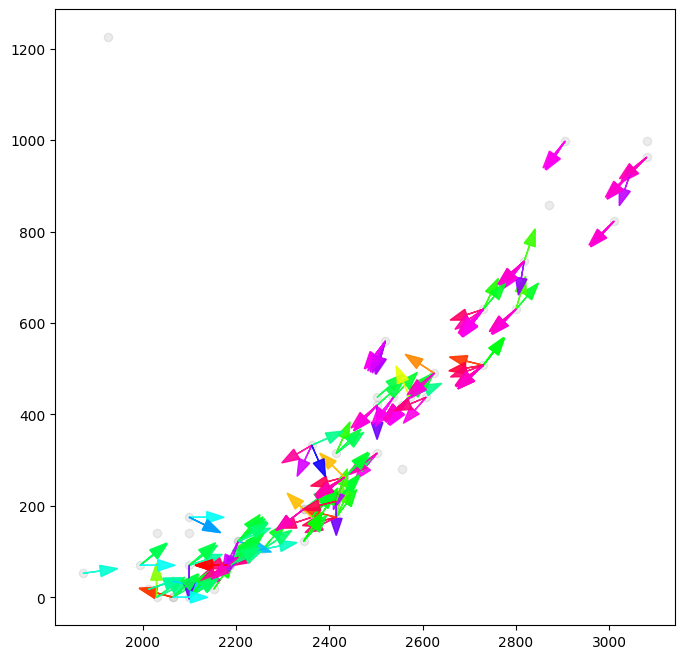

In [76]:
plot_vector_layout( sd, pairs)  

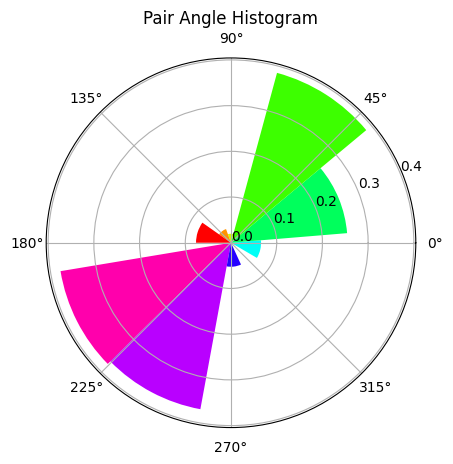

In [77]:
plot_latency_angle_hist(sd, pairs , by_firing_rate=True)

# <font color="purple"> Buzsaki P-Val 2

In [108]:

# Get all latencies whose STTC is above some minimum STTC cuttoff
print(sd.N**2 , "Starting Pairs")
sttc_neo = sd.spike_time_tilings( sttc_delta )    # sttc matrix   
pairs_sttc = []                            # get list (without duplicates) of all pairs above cutoff (excluding diagonal)
for i in range(sd.N):
    for j in range(i+1,sd.N):
        if sttc_neo[i,j] > sttc_cutoff:
            pairs_sttc.append([i,j])
print( len(pairs), "pairs above sttc cutoff")

# Get all latencies whose median latency is above some minimum Latency Cuttoff
pairs_late = [] #lags_late = []
for pair in pairs_sttc:
    pair_latencies = latencies( pair[0], pair[1], sd, ms_cutoff_high=20)  #latency= np.median(pair_latencies)
    if abs(np.median(pair_latencies))> 1 and len(pair_latencies)>20:
    #    pairs_late.append( pair )  #lags_late.append( latency )
        if np.median(pair_latencies) < 0:
            pairs_late.append( [pair[1], pair[0]] )  #lags_late.append( latency )
        else:
            pairs_late.append( pair )
#pairs= pairs_late
print( len(pairs_late), "pairs above latencency cutoff")

3025 Starting Pairs
208 pairs above sttc cutoff
300 pairs above latencency cutoff


In [109]:
# buszaki
cross_sttc_min_cutoff=1
cross_sttc_max_cutoff=8

pairs_pois = []
pvals = []
for pair in pairs_late:
    sttcs = cross_sttc( pair[0], pair[1], sd, delt=sttc_delta ) 
    sttcs_smth = gaussian_filter1d(sttcs, sigma=10)  

    sttcs_cutoff = sttcs[30+cross_sttc_min_cutoff:30+cross_sttc_max_cutoff]
    max_arg_cutoff = np.argwhere(sttcs_cutoff == np.amax(sttcs_cutoff))[0][0] 
    pois_n = max_arg_cutoff+cross_sttc_min_cutoff
    max_arg = max_arg_cutoff+30+cross_sttc_min_cutoff
    pois_lambda = sttcs_smth[max_arg]
    p_val = p_fast(pois_n, pois_lambda)
    if p_val < 0.0005:
        pairs_pois.append( pair )
        pvals.append( p_val )
pairs = np.array(pairs_pois)
print( len(pairs), "pairs above buzsaki")

/tmp/ipykernel_56309/1247081216.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  assert len(sd.neuron_data[0]) == len(sd.train)
/tmp/ipykernel_56309/1247081216.py:16: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  sttcs.append( sd.spike_time_tiling( len(sd.neuron_data[0]) , n2, delt= delt) )


208 pairs above buzsaki


In [110]:
# anticausal
#pairs = pairs_pois
pairs_pois_anti = []
pvals_anti = []
for pair in pairs_pois:
    sttcs = cross_sttc( pair[0], pair[1], sd, delt=sttc_delta ) 
    sttcs_smth = gaussian_filter1d(sttcs, sigma=10)  

    sttcs_cutoff = sttcs[30+cross_sttc_min_cutoff:30+cross_sttc_max_cutoff]
    max_arg_cutoff = np.argwhere(sttcs_cutoff == np.amax(sttcs_cutoff))[0][0] 
    pois_n = max_arg_cutoff+cross_sttc_min_cutoff
    max_arg = max_arg_cutoff+30+cross_sttc_min_cutoff
    pois_lambda = sttcs_smth[max_arg]
    p_val = p_fast(pois_n, pois_lambda)

    anti_sttcs_cutoff = sttcs[30-cross_sttc_max_cutoff:30-cross_sttc_min_cutoff]
    max_arg_cutoff = np.argwhere(anti_sttcs_cutoff == np.amax(anti_sttcs_cutoff))[0][-1] 
    max_arg = max_arg_cutoff+30-cross_sttc_max_cutoff
    pois_lambda = sttcs_smth[max_arg]
    anti_p_val = p_fast(pois_n, pois_lambda)

    if p_val < 0.0005 and anti_p_val<0.0005:
        pairs_pois_anti.append( pair )
        pvals_anti.append( p_val )
pairs_pois_anti = np.array(pairs_pois_anti)
print( len(pairs_pois_anti), "above buzsaki anti-causal")

/tmp/ipykernel_56309/1247081216.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  assert len(sd.neuron_data[0]) == len(sd.train)
/tmp/ipykernel_56309/1247081216.py:16: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  sttcs.append( sd.spike_time_tiling( len(sd.neuron_data[0]) , n2, delt= delt) )


207 above buzsaki anti-causal


In [111]:

# buszaki pval
pvals=np.array(pvals)
pairs_pois = np.array(pairs_pois)
pairs_pois2 = pairs_pois[pvals < 1e-11]
len(pairs_pois2)

# Anti pval
# pvals=np.array(pvals_anti)
# pairs_pois_anti = np.array(pairs_pois_anti)
# pairs_pois_final = pairs_pois_anti[pvals < 1e-11]
# len(pairs_pois2)


46

In [112]:
pairs_hisogram(pairs_pois_final, sd,  ms_cutoff_high=20 )

interactive(children=(IntSlider(value=22, description='pair', max=45), Output()), _dom_classes=('widget-intera…

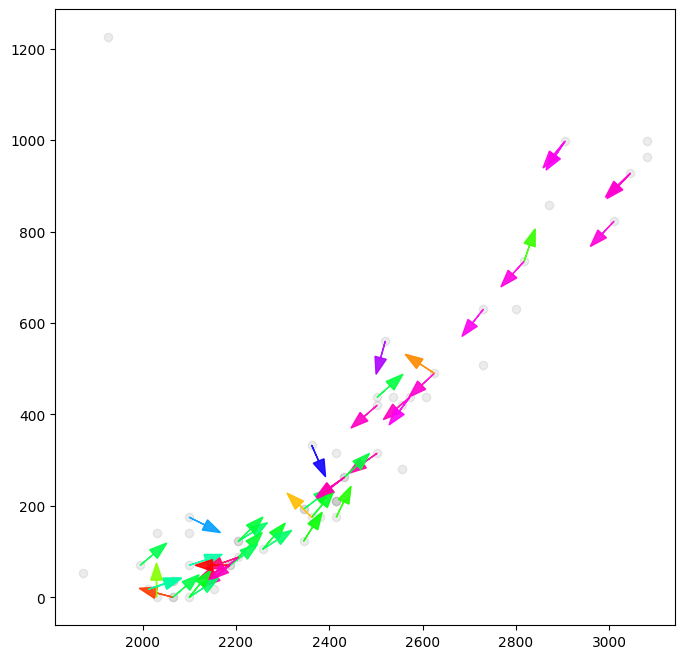

In [113]:
plot_vector_layout( sd, pairs_pois_final)  

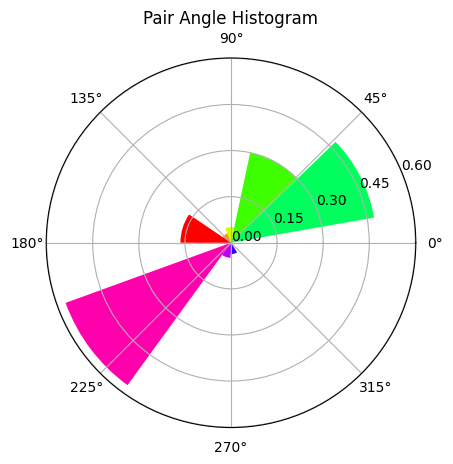

In [114]:
plot_latency_angle_hist(sd, pairs_pois_final , by_firing_rate=True)

# <font color="green"> Check Check Chek

In [15]:

# Get all latencies whose STTC is above some minimum STTC cuttoff
print(sd.N**2 , "Starting Pairs")
sttc_neo = sd.spike_time_tilings( 20 )    # sttc matrix   
pairs_sttc = []                            # get list (without duplicates) of all pairs above cutoff (excluding diagonal)
for i in range(sd.N):
    for j in range(i+1,sd.N):
        if sttc_neo[i,j] > .04:
            pairs_sttc.append([i,j])
print( len(pairs_sttc), "pairs above sttc cutoff")

# Get all latencies whose median latency is above some minimum Latency Cuttoff
pairs_late = [] #lags_late = []
for pair in pairs_sttc:
    pair_latencies = latencies( pair[0], pair[1], sd, ms_cutoff_high=20)  #latency= np.median(pair_latencies)
    if abs(np.median(pair_latencies))> 1.5 and len(pair_latencies)>20:
    #    pairs_late.append( pair )  #lags_late.append( latency )
        if np.mean(pair_latencies) < 0:
            pairs_late.append( [pair[1], pair[0]] )  #lags_late.append( latency )
        else:
            pairs_late.append( pair )
#pairs= pairs_late
print( len(pairs_late), "pairs above latencency cutoff")

3025 Starting Pairs
655 pairs above sttc cutoff
204 pairs above latencency cutoff


In [16]:
# buszaki
cross_sttc_min_cutoff=1
cross_sttc_max_cutoff=8

pairs_pois = []
pvals = []
for pair in pairs_late:
    sttcs = cross_sttc( pair[0], pair[1], sd, delt=20 ) 
    sttcs_smth = gaussian_filter1d(sttcs, sigma=10)  

    sttcs_cutoff = sttcs[30+cross_sttc_min_cutoff:30+cross_sttc_max_cutoff]
    max_arg_cutoff = np.argwhere(sttcs_cutoff == np.amax(sttcs_cutoff))[0][0] 
    pois_n = max_arg_cutoff+cross_sttc_min_cutoff
    max_arg = max_arg_cutoff+30+cross_sttc_min_cutoff
    pois_lambda = sttcs_smth[max_arg]
    p_val = p_fast(pois_n, pois_lambda)
    if p_val < 0.0005:
        pairs_pois.append( pair )
        pvals.append( p_val )
pairs_pois = np.array(pairs_pois)
print( len(pairs_pois), "pairs above buzsaki")

/tmp/ipykernel_1236/1247081216.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  assert len(sd.neuron_data[0]) == len(sd.train)
/tmp/ipykernel_1236/1247081216.py:16: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  sttcs.append( sd.spike_time_tiling( len(sd.neuron_data[0]) , n2, delt= delt) )


143 pairs above buzsaki


In [17]:
# anticausal
#pairs = pairs_pois
pairs_pois_anti = []
pvals_anti = []
for pair in pairs_pois:
    sttcs = cross_sttc( pair[0], pair[1], sd, delt=20 ) 
    sttcs_smth = gaussian_filter1d(sttcs, sigma=10)  

    sttcs_cutoff = sttcs[30+cross_sttc_min_cutoff:30+cross_sttc_max_cutoff]
    max_arg_cutoff = np.argwhere(sttcs_cutoff == np.amax(sttcs_cutoff))[0][0] 
    pois_n = max_arg_cutoff+cross_sttc_min_cutoff
    max_arg = max_arg_cutoff+30+cross_sttc_min_cutoff
    pois_lambda = sttcs_smth[max_arg]
    p_val = p_fast(pois_n, pois_lambda)

    anti_sttcs_cutoff = sttcs[30-cross_sttc_max_cutoff:30-cross_sttc_min_cutoff]
    max_arg_cutoff = np.argwhere(anti_sttcs_cutoff == np.amax(anti_sttcs_cutoff))[0][-1] 
    max_arg = max_arg_cutoff+30-cross_sttc_max_cutoff
    pois_lambda = sttcs_smth[max_arg]
    anti_p_val = p_fast(pois_n, pois_lambda)

    if p_val < 0.0005 and anti_p_val<0.0005:
        pairs_pois_anti.append( pair )
        pvals_anti.append( p_val )
pairs_pois_anti = np.array(pairs_pois_anti)
print( len(pairs_pois_anti), "above buzsaki anti-causal")

/tmp/ipykernel_1236/1247081216.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  assert len(sd.neuron_data[0]) == len(sd.train)
/tmp/ipykernel_1236/1247081216.py:16: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  sttcs.append( sd.spike_time_tiling( len(sd.neuron_data[0]) , n2, delt= delt) )


143 above buzsaki anti-causal


In [18]:

# buszaki pval
pvals=np.array(pvals)
pairs_final = pairs_pois[pvals < 1e-5]
len(pairs_final)

# Anti pval
# pvals=np.array(pvals_anti)
# pairs_pois_anti = np.array(pairs_pois_anti)
# pairs_pois_final = pairs_pois_anti[pvals < 1e-11]
# len(pairs_pois2)


121

In [19]:
pairs_hisogram(pairs_final, sd,  ms_cutoff_high=20 )

interactive(children=(IntSlider(value=60, description='pair', max=120), Output()), _dom_classes=('widget-inter…

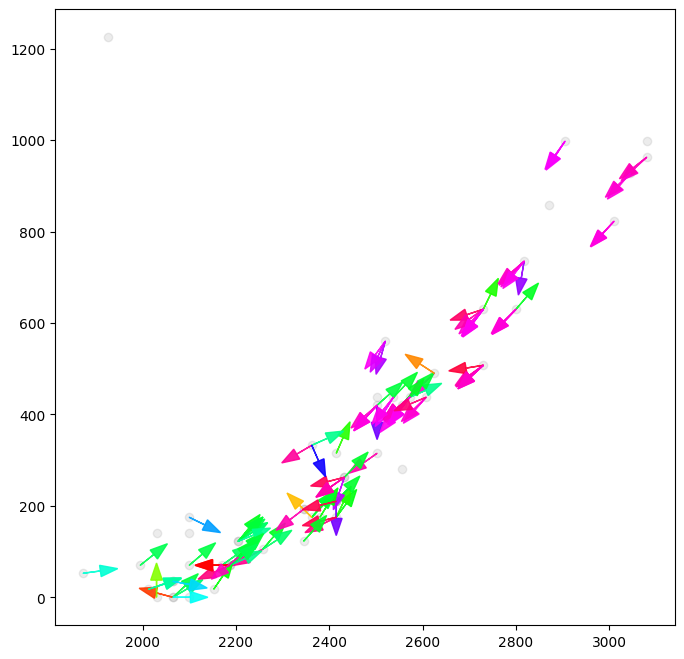

In [20]:
plot_vector_layout( sd, pairs_final)  

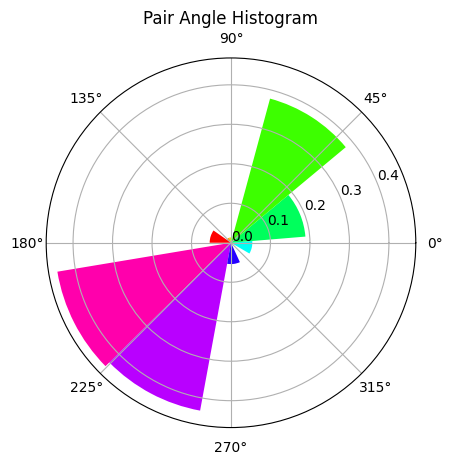

In [21]:
plot_latency_angle_hist(sd, pairs_final , by_firing_rate=False)

# Mek Mek Mek

In [33]:

# Get all latencies whose STTC is above some minimum STTC cuttoff
print(sd.N**2 , "Starting Pairs")
sttc_neo = sd.spike_time_tilings( 20 )    # sttc matrix   
pairs_sttc = []                            # get list (without duplicates) of all pairs above cutoff (excluding diagonal)
for i in range(sd.N):
    for j in range(i+1,sd.N):
        if sttc_neo[i,j] > .04:
            pairs_sttc.append([i,j])
print( len(pairs_sttc), "pairs above sttc cutoff")

# Get all latencies whose median latency is above some minimum Latency Cuttoff
pairs_late = [] #lags_late = []
for pair in pairs_sttc:
    pair_latencies = latencies( pair[0], pair[1], sd, ms_cutoff_high=15)  #latency= np.median(pair_latencies)
    if abs(np.mean(pair_latencies))> 1.3 and len(pair_latencies)>20:
    #    pairs_late.append( pair )  #lags_late.append( latency )
        if np.mean(pair_latencies) < 0:
            pairs_late.append( [pair[1], pair[0]] )  #lags_late.append( latency )
        else:
            pairs_late.append( pair )
#pairs= pairs_late
print( len(pairs_late), "pairs above latencency cutoff")

3025 Starting Pairs
655 pairs above sttc cutoff
95 pairs above latencency cutoff


In [34]:
# buszaki
cross_sttc_min_cutoff=1
cross_sttc_max_cutoff=8

pairs_pois = []
pvals = []
for pair in pairs_late:
    sttcs = cross_sttc( pair[0], pair[1], sd, delt=20 ) 
    sttcs_smth = gaussian_filter1d(sttcs, sigma=10)  

    sttcs_cutoff = sttcs[30+cross_sttc_min_cutoff:30+cross_sttc_max_cutoff]
    max_arg_cutoff = np.argwhere(sttcs_cutoff == np.amax(sttcs_cutoff))[0][0] 
    pois_n = max_arg_cutoff+cross_sttc_min_cutoff
    max_arg = max_arg_cutoff+30+cross_sttc_min_cutoff
    pois_lambda = sttcs_smth[max_arg]
    p_val = p_fast(pois_n, pois_lambda)
    if p_val < 0.0005:
        pairs_pois.append( pair )
        pvals.append( p_val )
pairs_pois = np.array(pairs_pois)
print( len(pairs_pois), "pairs above buzsaki")

/tmp/ipykernel_26576/1247081216.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  assert len(sd.neuron_data[0]) == len(sd.train)
/tmp/ipykernel_26576/1247081216.py:16: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  sttcs.append( sd.spike_time_tiling( len(sd.neuron_data[0]) , n2, delt= delt) )


61 pairs above buzsaki


In [35]:
# anticausal
#pairs = pairs_pois
pairs_pois_anti = []
pvals_anti = []
for pair in pairs_pois:
    sttcs = cross_sttc( pair[0], pair[1], sd, delt=20 ) 
    sttcs_smth = gaussian_filter1d(sttcs, sigma=10)  

    sttcs_cutoff = sttcs[30+cross_sttc_min_cutoff:30+cross_sttc_max_cutoff]
    max_arg_cutoff = np.argwhere(sttcs_cutoff == np.amax(sttcs_cutoff))[0][0] 
    pois_n = max_arg_cutoff+cross_sttc_min_cutoff
    max_arg = max_arg_cutoff+30+cross_sttc_min_cutoff
    pois_lambda = sttcs_smth[max_arg]
    p_val = p_fast(pois_n, pois_lambda)

    anti_sttcs_cutoff = sttcs[30-cross_sttc_max_cutoff:30-cross_sttc_min_cutoff]
    max_arg_cutoff = np.argwhere(anti_sttcs_cutoff == np.amax(anti_sttcs_cutoff))[0][-1] 
    max_arg = max_arg_cutoff+30-cross_sttc_max_cutoff
    pois_lambda = sttcs_smth[max_arg]
    anti_p_val = p_fast(pois_n, pois_lambda)

    if p_val < 0.0005 and anti_p_val<0.0005:
        pairs_pois_anti.append( pair )
        pvals_anti.append( p_val )
pairs_pois_anti = np.array(pairs_pois_anti)
print( len(pairs_pois_anti), "above buzsaki anti-causal")

/tmp/ipykernel_26576/1247081216.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  assert len(sd.neuron_data[0]) == len(sd.train)
/tmp/ipykernel_26576/1247081216.py:16: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  sttcs.append( sd.spike_time_tiling( len(sd.neuron_data[0]) , n2, delt= delt) )


61 above buzsaki anti-causal


In [36]:

# buszaki pval
pvals=np.array(pvals)
pairs_final = pairs_pois[pvals < 1e-5]
len(pairs_final)

# Anti pval
# pvals=np.array(pvals_anti)
# pairs_pois_anti = np.array(pairs_pois_anti)
# pairs_pois_final = pairs_pois_anti[pvals < 1e-11]
# len(pairs_pois2)


51

In [37]:
pairs_hisogram(pairs_final, sd,  ms_cutoff_high=20 )

interactive(children=(IntSlider(value=25, description='pair', max=50), Output()), _dom_classes=('widget-intera…

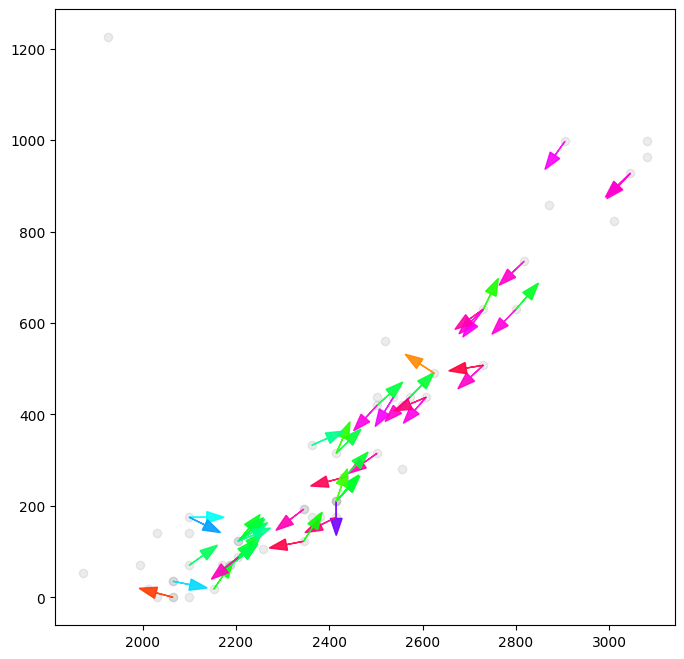

In [38]:
plot_vector_layout( sd, pairs_final)  

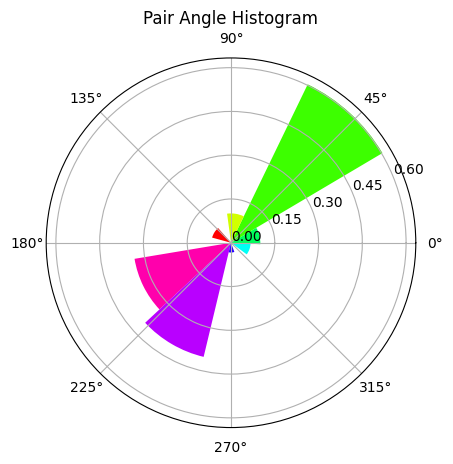

In [39]:
plot_latency_angle_hist(sd, pairs_final , by_firing_rate=False)